In [2]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D,GlobalAveragePooling2D,
                                     Activation, Flatten, Dropout, Dense, Lambda)

from keras.initializers import glorot_uniform
from keras.utils.layer_utils import get_source_inputs
#from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
import math

In [4]:
def dic_group(path):
    #initialize an empty list
    list_name=[]
    #get the signature files in the path
    for root, dirs, files in os.walk(path):
        #store the files in the list
        list_name.extend(files)
    #import default dict
    from collections import defaultdict
    #initialize a dictionary of lists
    dic=defaultdict(list)
    #loop through the list of files
    for i in list_name:
        #split the file into name and extension
        filename, ext = os.path.splitext(i)
        #split the filename into category(forged/genuine), example(single individual) and image index
        cat, ex, img_index=filename.split('_')
        #populate the dictionary
        dic[ex].append(img_index)
    return dic

In [5]:
#create a new directory that stores sub-directories which contain signatures for individual persons
#return the path of the new directory
def create_dir(new_dir, parent_dir):
    path=os.path.join(parent_dir, new_dir)
    os.mkdir(path)
    new_folder_path=parent_dir+'/'+new_dir
    return new_folder_path

In [6]:
#the function takes dictionary of lists with image indexes, a new folder created by create_dir function and the
#category of the signatures, i.e genuine/ forgeries
def create_groups(dic,new_dir,path,cat):
    
    #loop through the dictionary of signatures
    for i in dic:
        #if a sub-directory i that stores signatures for person i does not exist inside the new directory new_dir
        if not os.path.exists(os.path.join(new_dir, i)):
            #create a sub-directory called i inside the new directory
            os.mkdir(os.path.join(new_dir, i))
            #loop through the list in dic[i]
            for img in dic[i]:
                #location of the image
                old_image=os.path.join(path,'{}_{}_{}.png'.format(cat,i,img))
                #new name for the image
                new_image= 'r{}.png'.format(img)
                new_path=os.path.join(new_dir,i)
                #move the .png files to new folder
                shutil.move(old_image, os.path.join(new_path,new_image))
        else:
            for img in dic[i]:
                #location of the image
                old_image=os.path.join(path,'{}_{}_{}.png'.format(cat,i,img))
                #new name for the image
                new_image= 'r{}.png'.format(img)
                new_path=os.path.join(new_dir,i)
                print(new_path)
                shutil.move(old_image,os.path.join(new_path,new_image))
            

In [7]:
#function to create a list of lists, with each list containing signature images of a single person
def sig_path_list(path):
    #create a list of directories containing signatures of individuals
    dir_list=next(os.walk(path))[1]
    #sort the list
    dir_list.sort()
    #create an empty list
    group=[]
    for directory in dir_list:
        images = os.listdir(path+'/'+directory)
        images.sort()
        images = [path+'/'+directory+'/'+x for x in images]
        group.append(images) 
    return group

In [8]:
!pip install opendatasets

In [9]:
import opendatasets as od
od.download("https://www.kaggle.com/hashbanger/signatures-recognition-full?select=signatures_full")
! unzip <signatures_full>

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anthonykahuro
Your Kaggle Key: ··········


100%|██████████| 241M/241M [00:01<00:00, 138MB/s]



/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: ` unzip <signatures_full>'


In [10]:
import shutil
path='./signatures-recognition-full/signatures_full/train/forged'
dic_forged=dic_group(path)
forged_person=create_dir("forged_person", path)
create_groups(dic_forged,forged_person,path,"forgeries")

In [11]:
path='./signatures-recognition-full/signatures_full/train/genuine'
dic_genuine=dic_group(path)
genuine_person=create_dir("genuine_person", path)
create_groups(dic_genuine,genuine_person,path,"original")

In [12]:
path='./signatures-recognition-full/signatures_full/test/forged'
dic_forged=dic_group(path)
forged_person=create_dir("forged_person", path)
create_groups(dic_forged,forged_person,path,"forgeries")

In [13]:
path='./signatures-recognition-full/signatures_full/test/genuine'
dic_genuine=dic_group(path)
genuine_person=create_dir("genuine_person", path)
create_groups(dic_genuine,genuine_person,path,"original")

In [14]:
#create groups of lists
path='./signatures-recognition-full/signatures_full/train/forged/forged_person'
forg_groups=sig_path_list(path)

path='./signatures-recognition-full/signatures_full/train/genuine/genuine_person'
genuine_groups=sig_path_list(path)

In [15]:
len(forg_groups),len(genuine_groups)

(55, 55)

In [16]:
#split data into training and validation
#40 individuals for training and 15 for validation
orig_train, orig_val = genuine_groups[:40], genuine_groups[40:]
forg_train, forg_val = forg_groups[:40], forg_groups[40:]

In [17]:
# All the images will be converted to the same size before processing
img_h, img_w = 155,220

In [18]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    #create the axes of the plots. 1 row and 3 columns for three images to be outputed
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 15))
    #randomly select and index in the range of the training set size
    k = np.random.randint(len(orig_train))
    #randomly get two original signatures for person k
    orig_img_names = random.sample(orig_train[k], 2)
    #randomly get one forged signature in for person k
    forg_img_name = random.sample(forg_train[k], 2)
    #read images using open cv module
    orig_img1 = plt.imread(orig_img_names[0], 0)
    orig_img2 = plt.imread(orig_img_names[1], 0)
    forg_img1 = plt.imread(forg_img_name[0], 0)
    forg_img2 = plt.imread(forg_img_name[1], 0)
    #resize the images
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img1 = cv2.resize(forg_img1, (img_w, img_h))
    forg_img2 = cv2.resize(forg_img2, (img_w, img_h))
    #plot the images

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img1, cmap = 'gray')
    ax4.imshow(forg_img2, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')
    ax4.set_title('Forged Copy')
    ax4.axis('off')

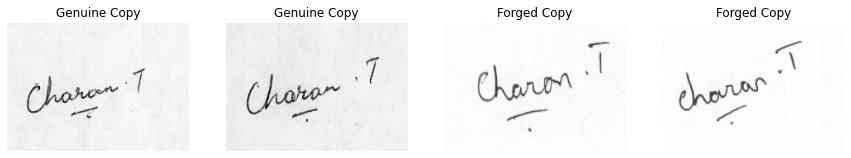

In [19]:
visualize_sample_signature()

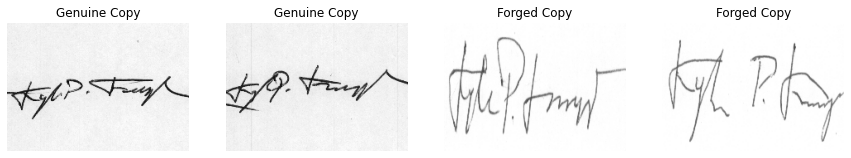

In [20]:
visualize_sample_signature()

In [21]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 20 genuine signatures, hence we have 
        # 20 choose 2 = 190 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 20 * 12 = 240 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 40 * 190= 7600
        # Total number of Genuine-Forged pairs = 40 * 240 = 9600
        # Total no. of data points = 7600 + 9600 = 17200
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, math.ceil(0.6*len(forg_groups[0]))))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [22]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [23]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [24]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [25]:
def build_siamese_model(inputShape, embeddingDim=48):
    
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
    # prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [26]:
input_shape=(img_h, img_w, 1)
batch_sz = 128
num_train_samples = 40 * 190 + 40 * 240
num_val_samples = 190*15 + 240*15
num_train_samples, num_val_samples

(17200, 6450)

In [27]:
base_network= build_siamese_model(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [28]:
# compile model using Adam Optimizer and Contrastive loss function defined above
model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-6))

In [29]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 2,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              )

Epoch 1/2
134/134 [==============================] - 150s 1s/step - loss: 0.4817 - val_loss: 0.5166
Epoch 2/2
134/134 [==============================] - 178s 1s/step - loss: 0.4797 - val_loss: 0.5158


In [30]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    #maximum distance
    dmax = np.max(predictions)
    #minimum distance
    dmin = np.min(predictions)
    #number of gen-gen signatures 
    nsame = np.sum(labels == 1)
    #number of gen-forg signatures
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame     #percentage of correctly predicted genuine signatures  among all genuine signatures
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff  
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [31]:
#size of test samples
num_test_samples = (55 * 6)+(55 * 12)

In [32]:
path='./signatures-recognition-full/signatures_full/test/genuine/genuine_person'
genuine_groups_test=sig_path_list(path)

path='./signatures-recognition-full/signatures_full/test/forged/forged_person'
forged_groups_test=sig_path_list(path)

In [33]:
#use a batch size of 1 when generating the test set
#to get all the test data plus the respective labels, loop number of test samples times
test_gen = generate_batch(genuine_groups_test, forged_groups_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [34]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.9954545454545454, 0.020518006563652307)

In [36]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

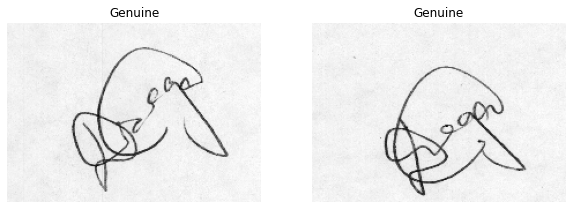

Difference Score =  0.009488361
Its a Genuine Signature


In [37]:
predict_score()

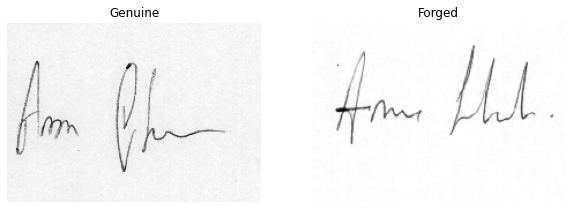

Difference Score =  0.046658307
Its a Forged Signature


In [38]:
predict_score()

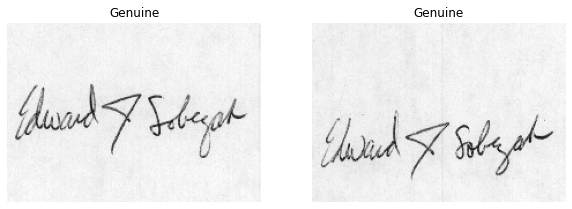

Difference Score =  0.014113968
Its a Genuine Signature


In [39]:
predict_score()

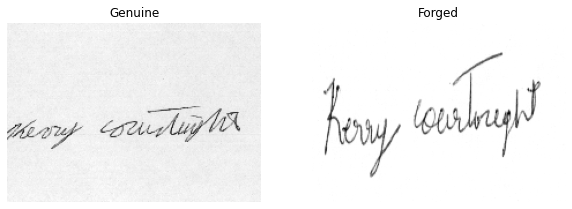

Difference Score =  0.03889809
Its a Forged Signature


In [40]:
predict_score()